# 9.7.4 Water Management

From Miranda and Fackler, Applied Computational Economics and Finance, 2002, Section 9.7.4

貯水池の水を灌漑用水とレクリエーションに使うことができる。年初に $s$ 単位の水が貯水池にあって、灌漑に $x$ 単位使われたとき、農家とレクリエーション使用者のその年の利益はそれぞれ $F(x)$ と $U(s-x)$ になる。貯水池の水は冬季にランダムに $\epsilon$ 単位降る雨によって補充される。貯水池は最大 $M$ 単位の水しか貯められない。

このモデルは an infinite horizon ,stochastic model である。

The state variable: $s \in [0, M]$ …年初の貯水池の水量。

The action variable: $x \in [0, s]$ …灌漑に使われる水量。

The state transition function: $g(s, x, \epsilon) = min(s - x + \epsilon, M)$

The reward function: $f(s, x) = F(x) + U(s - x)$

年初に $s$ 単位の水がある貯水池の社会的価値がベルマン方程式を満たす。

$V(s) = \max_{0 \leq x \leq s}\{F(x) + U(s - x) + \delta E_\epsilon V (min(s - x + \epsilon, M)\}$

$F'(0), U'(0), M$ が十分に大きいと仮定すると、最適解において制約が束縛されないので、水の潜在価格 $\lambda(s)$ はオイラーの平衡条件を満たす。

$F'(x) - U'(s - x) - \delta E_\epsilon \lambda (s - x + \epsilon) = 0$

$\lambda(s) = U'(s - x) + \delta E_\epsilon \lambda (s - x + \epsilon)$

このことは最適経路の周辺で $F'_t = U'_t + \delta E_t \lambda_{t + 1}$ が成立することを示す。

確実性等価での安定状態での貯水池の水量 $s^*$ 、灌漑に用いる水量 $x^*$ 、潜在価格 $\lambda^*$ で方程式を解くと、

$x^* = \bar{\epsilon}$

$F'(x^*) = \lambda^*$

$U'(s^* - x^*) = (1 - \delta)F'(x^*)$

ここで $\bar{\epsilon}$ は年間の平均降水量である。この条件は $x^*$ と $\lambda^*$ は割引因子の影響を受けず、 $s^*$ は割引因子の影響を受けることを示す。

In [1]:
using QuantEcon
using BasisMatrices
using Optim 
using Plots

In [2]:
struct WaterManagement
    a1::Float64
    a2::Float64
    b1::Float64
    b2::Float64
    sigma::Float64
    delta::Float64
    s_vec::Vector{Float64}
end

In [3]:
n = 10
smin = 2
smax = 7
fspace = Basis(ChebParams(n, smin, smax))
snodes = nodes(fspace)

([2.03078, 2.27248, 2.73223, 3.36502, 4.10891, 4.89109, 5.63498, 6.26777, 6.72752, 6.96922], Array{Float64,1}[[2.03078, 2.27248, 2.73223, 3.36502, 4.10891, 4.89109, 5.63498, 6.26777, 6.72752, 6.96922]])

In [4]:
WM =WaterManagement(1, 2, -2, -3, 0.2, 0.9, snodes[1])

WaterManagement(1.0, 2.0, -2.0, -3.0, 0.2, 0.9, [2.03078, 2.27248, 2.73223, 3.36502, 4.10891, 4.89109, 5.63498, 6.26777, 6.72752, 6.96922])

### 一次線形補間

In [5]:
a1, a2, b1, b2, sigma, delta = WM.a1, WM.a2, WM.b1, WM.b2, WM.sigma, WM.delta

(1.0, 2.0, -2.0, -3.0, 0.2, 0.9)

In [6]:
nshocks = 3
epsilon, weight = qnwlogn(nshocks, 0, WM.sigma^2)

([0.707222, 1.0, 1.41398], [0.166667, 0.666667, 0.166667])

In [7]:
function update_Bellman1(WM::WaterManagement, V::Vector)
    a1, a2, b1, b2, sigma, delta = WM.a1, WM.a2, WM.b1, WM.b2, WM.sigma, WM.delta
    V_new = similar(V)
    x_opt = similar(V)
    V_func = LinInterp(WM.s_vec, V)
    
    for (s_idx, s) in enumerate(WM.s_vec)
        objective(x) = -(a1/(1+b1) * x^(1+b1) + a2/(1+b2) * (s-x)^(1+b2)
                       + delta * dot(weight ,V_func.(s-x+epsilon)))
        opt = optimize(objective, 1e-10, s)
        V_new[s_idx] = - opt.minimum
        x_opt[s_idx] = opt.minimizer
    end
    
    return V_new, x_opt
    
end

update_Bellman1 (generic function with 1 method)

In [8]:
# Initial guess
V = zeros(length(WM.s_vec));

In [9]:
V_computed = similar(V)
x_opt = similar(V)
resid1 = Vector{Float64}(n)
tol = sqrt(eps())
max_iter = 500
V_error = 1.0
i = 1

while V_error > tol && i <= max_iter
    V_computed, x_opt = update_Bellman1(WM, V)
    V_error = maximum(abs, V_computed - V) 
    for j in 1:length(V_computed)
       resid1[j] =  V_computed[j] - V[j]
    end
    copy!(V, V_computed)
    i += 1
end


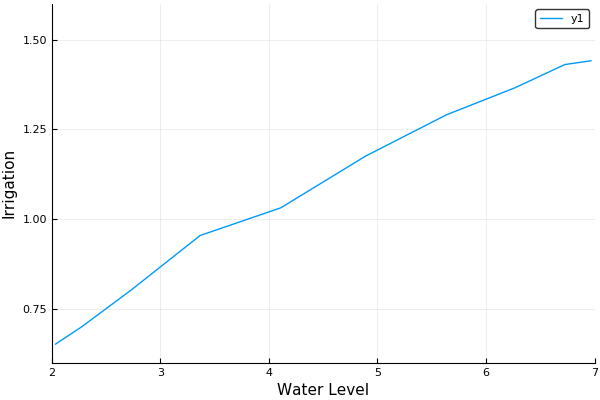

In [10]:
plot(WM.s_vec, x_opt, xlabel="Water Level", ylabel="Irrigation", xlim=(2, 7), ylim=(0.6, 1.6))

### Chebychev Collocation

In [11]:
n = 10
s_min = 2
s_max = 7
basis = Basis(ChebParams(n, s_min, s_max))

1 dimensional Basis on the hypercube formed by (2.0,) × (7.0,).
Basis families are Cheb


In [12]:
S, _ = nodes(basis)
Phi = BasisMatrix(basis, Expanded(), S).vals[1]

10×10 Array{Float64,2}:
 1.0  -0.987688   0.951057     -0.891007  …  -0.45399    0.309017  -0.156434
 1.0  -0.891007   0.587785     -0.156434      0.987688  -0.809017   0.45399 
 1.0  -0.707107   2.22045e-16   0.707107     -0.707107   1.0       -0.707107
 1.0  -0.45399   -0.587785      0.987688     -0.156434  -0.809017   0.891007
 1.0  -0.156434  -0.951057      0.45399       0.891007   0.309017  -0.987688
 1.0   0.156434  -0.951057     -0.45399   …  -0.891007   0.309017   0.987688
 1.0   0.45399   -0.587785     -0.987688      0.156434  -0.809017  -0.891007
 1.0   0.707107   2.22045e-16  -0.707107      0.707107   1.0        0.707107
 1.0   0.891007   0.587785      0.156434     -0.987688  -0.809017  -0.45399 
 1.0   0.987688   0.951057      0.891007      0.45399    0.309017   0.156434

In [13]:
function update_Bellman2(WM::WaterManagement, C::Vector)
    a1, a2, b1, b2, sigma, delta = WM.a1, WM.a2, WM.b1, WM.b2, WM.sigma, WM.delta
    V_new = similar(C)
    x_opt = similar(C)
    
    for (s_idx, s) in enumerate(S)
        objective(x) = -(a1/(1+b1) * x^(1+b1) + a2/(1+b2) * (s-x)^(1+b2)
                       + delta * dot(weight, funeval(C, basis, s - x + epsilon)))
        opt = optimize(objective, 0, s)
        V_new[s_idx] = - opt.minimum
        x_opt[s_idx] = opt.minimizer
    end
    C_new = Phi \ V_new
    return C_new, x_opt
    
end

update_Bellman2 (generic function with 1 method)

In [14]:
C = zeros(n);

In [15]:
C_computed = similar(C)
x_opt = similar(C)
tol = sqrt(eps())
max_iter = 500
C_error = 1.0
i = 1

while C_error > tol && i <= max_iter
    C_computed, x_opt = update_Bellman2(WM, C)
    C_error = maximum(abs, C_computed - C) 
    copy!(C, C_computed)
    i += 1
end

In [16]:
i, C_error, x_opt

(175, 1.4292689698436334e-8, [0.641035, 0.702795, 0.809586, 0.938495, 1.07091, 1.19403, 1.30031, 1.38446, 1.44255, 1.47223])

In [17]:
ss = linspace(s_min, s_max, 50)
x_opt = Array{Float64}(length(ss))
for (s_idx, s) in enumerate(ss)
    objective(x) = -(a1/(1+b1) * x^(1+b1) + a2/(1+b2) * (s-x)^(1+b2)
                   + delta * dot(weight ,funeval(C, basis, s - x + epsilon)))
    opt = optimize(objective, 0, s)
    x_opt[s_idx] = opt.minimizer
end

In [18]:
B1 = evalbase(basis.params[1], ss, 1)
cheb_shadow_prices = B1 * C;

### Linear Quadratic approximation

In [19]:
function approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, discount)
    n = 2  # Dim of state variable (1, s)
    k = 1  # Dim of control variable x
    sx_star = [s_star, x_star]
    
    # (1, s)' R (1, s) + 2 x N (1, s) + x Q x
    Q = Array{Float64}(k, k)
    R = Array{Float64}(n, n)
    N = Array{Float64}(k, n)
    R[1, 1] = -(f_star - Df_star' * sx_star + (sx_star' * DDf_star * sx_star) / 2)
    R[2, 2], N[1, 2], N[1, 2], Q[1, 1] = -DDf_star / 2
    R[2, 1], N[1, 1] = -(Df_star - DDf_star * sx_star) / 2
    R[1, 2] = R[2, 1]
    
    # A (1, s) + B x + C w
    A = Array{Float64}(n, n)
    B = Array{Float64}(n, k)
    C = zeros(n, 1)
    A[1, 1], A[1, 2], B[1, 1] = 1, 0, 0
    A[2, 1] = g_star - Dg_star' * sx_star
    A[2, 2], B[2, 1] = Dg_star
    
    lq = LQ(Q, R, A, B, C, N, bet=discount)
    return lq
end

approx_lq (generic function with 1 method)

In [20]:
estar = exp(-sigma^2/2)

0.9801986733067553

In [21]:
f(s, x) = a1 * x^(1+b1)/(1 + b1) + a2 * (s - x)^(1 + b2)/(1 + b2)
f_s(s, x) = a2 * (s - x)^b2
f_x(s, x) = a1 * x^b1 - a2 * (s - x)^b2 
f_ss(s, x) = a2 * b2 * (s - x)^(b2 - 1)
f_sx(s, x) = -a2 * b2 * (s - x)^(b2 - 1)
f_xx(s, x) = a1 * b1 * x^(b1 - 1) + a2 * b2 * (s - x)^(b2 - 1)

g(s, x) = s - x + estar
g_s(s, x) = 1
g_x(s, x) = -1;

In [22]:
x_star = 1
s_star = 1 + (a1 * (1 - delta)/a2)^(1/b2)
s_star, x_star

(3.7144176165949068, 1)

In [23]:
f_x(s_star, x_star) + delta * f_s(g(s_star, x_star), x_star) * g_x(s_star, x_star)

0.8080012953777312

In [24]:
f_star = f(s_star, x_star)
Df_star = [f_s(s_star, x_star), f_x(s_star, x_star)]
DDf_star = [f_ss(s_star, x_star) f_sx(s_star, x_star);
            f_sx(s_star, x_star) f_xx(s_star, x_star)]
g_star = g(s_star, x_star)
Dg_star = [g_s(s_star, x_star), g_x(s_star, x_star)];

In [25]:
lq = approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, delta)

QuantEcon.LQ([1.05526], [3.81433 -0.2; -0.2 0.0552605], [1.0 0.0; 0.980199 1.0], [0.0; -1.0], [0.0; 0.0], [-1.3 -0.0552605], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

In [26]:
P, F, d = stationary_values(lq)

([17.757 -1.16418; -1.16418 0.176119], [-0.335817 -0.176119], 0.0)

In [27]:
V_LQ(s) = [1, s]' * P * [1, s] + d

V_LQ (generic function with 1 method)

In [28]:
V_LQ(s_star)

11.538393067945846

In [29]:
-f_star / (1 - lq.bet)

11.357208808297454

In [30]:
X_LQ(s) = - (F * [1, s])[1]

X_LQ (generic function with 1 method)

In [31]:
X_LQ(s_star)

0.9899968896779613

In [32]:
x_star

1


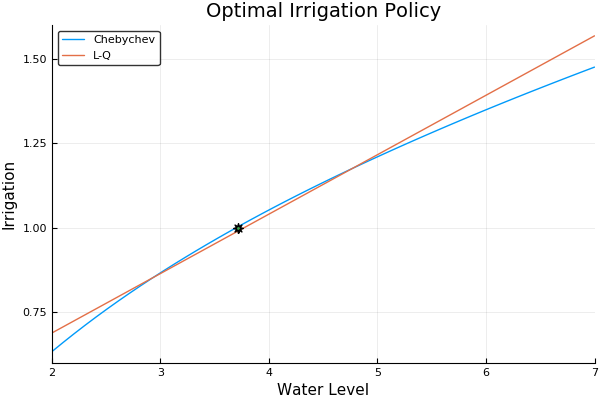

In [33]:
s_min, s_max = 2, 7
ys = [x_opt, X_LQ.(ss)]
title = "Optimal Irrigation Policy"
xlabel = "Water Level"
ylabel = "Irrigation"
labels = ["Chebychev" "L-Q"]
plot(ss, ys, xlims=(s_min, s_max), ylims=(0.6, 1.6),
     title=title, xlabel=xlabel, ylabel=ylabel, label = labels)
plot!([s_star], [x_star], m=(7,:star8), label="")


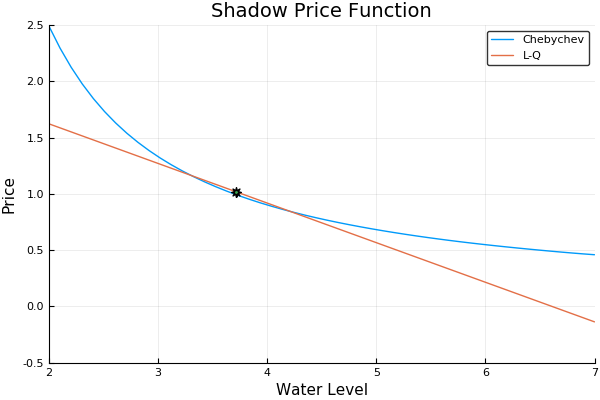

In [34]:
lq_shadow_price(s) = -2 * (P * [1, s])[2]
ys = [cheb_shadow_prices, lq_shadow_price.(ss)]
title = "Shadow Price Function"
ylabel = "Price"
labels = ["Chebychev" "L-Q"]
plot(ss, ys, xlims=(s_min, s_max), ylims=(-0.5, 2.5),
     title=title, xlabel=xlabel, ylabel=ylabel, label=labels)
plot!([s_star], [lq_shadow_price(s_star)], m=(7,:star8), label="")

In [35]:
V_new = Array{Float64}(length(ss))
for (s_idx, s) in enumerate(ss)
    objective(x) = -(a1/(1+b1) * x^(1+b1) + a2/(1+b2) * (s-x)^(1+b2)
                   + delta * dot(weight ,funeval(C, basis, s - x + epsilon)))
    opt = optimize(objective, 0, s)
    V_new[s_idx] = -opt.minimum
end
Resid = V_new - funeval(C, basis, ss);


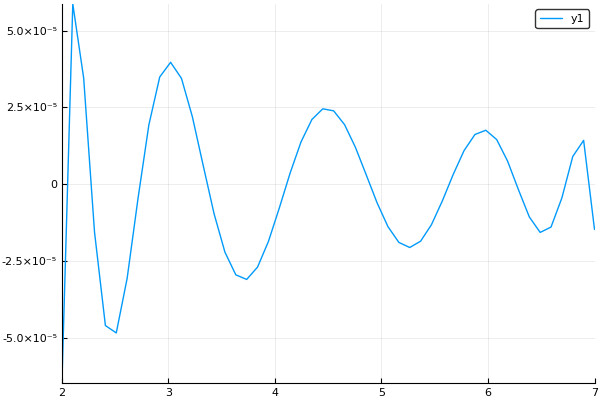

In [36]:
plot(ss, Resid, yformatter=:scientific)